In [1]:
import lib_lamune as lmn
lmn.reload(lmn)

<module 'lib_lamune' from 'd:\\#Desktop\\Git\\Github\\Lamune_Util\\lib_lamune.py'>

In [3]:
# # 그래프 한글 출력 깨짐 해결
# import matplotlib.font_manager
# import matplotlib.pyplot as plt
# import matplotlib as mpl

# [f.name for f in matplotlib.font_manager.fontManager.ttflist if 'Nanum' in f.name]
# [f.name for f in matplotlib.font_manager.fontManager.ttflist if 'D2' in f.name]

# plt.style.use('ggplot')
# font = {'size': 12,
#         #'family': 'NanumBarunGothic'}
#         'family': 'Malgun Gothic'}
# mpl.rc('font', **font)

In [23]:
# data loading 
import parquet
import pandas as pd 

path_save = "../PRJ_02/data_save/"
fileName = "01_Data_합친것.parquet"
df_all_data = pd.read_parquet(f"{path_save}/{fileName}", engine='pyarrow') 

fileName = "01_target.parquet"
df_target_all = pd.read_parquet(f"{path_save}/{fileName}", engine='pyarrow') 


In [27]:
# 데이터 전처리
# df_x_clean = df_all_data.fillna(0)
# # df_target_all = df_target_all.fillna(0)
df_x_clean = df_all_data
df_y_clean = df_target_all['미래환율_증가여부']

# from sklearn.preprocessing import LabelEncoder

# le = LabelEncoder()
# df_y_clean = le.fit_transform(df_y_clean)

In [25]:
np.median(df_y_clean)

0.0

In [28]:
# data split 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split( df_x_clean ,df_y_clean  , test_size=0.2, random_state=42 , stratify=df_y_clean )
X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train , test_size=0.2, random_state=42  , stratify=y_train )

In [31]:
#평가 지표 
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score , roc_auc_score , confusion_matrix

def get_clf_eval(y_test, y_pred=None, pred_proba=None):

    # print( "y_test = ", y_test.shape , y_test )
    # print( "y_pred = ", y_pred.shape , y_pred )
    # print( "pred_proba = ", pred_proba.shape , pred_proba )

    confusion = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred)
    AUC = roc_auc_score(y_test, pred_proba)

    print('오차행렬:\n', confusion)
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('F1: {:.4f}'.format(F1))
    print('AUC: {:.4f}'.format(AUC))

In [32]:
# 모델 학습
from lightgbm import LGBMClassifier
from lightgbm import plot_importance

#학습
lgbm_wrapper = LGBMClassifier(n_estimators=400)
evals = [(X_test, y_test)]
lgbm_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric='logloss', eval_set=evals, verbose=False)

#예측
y_pred = lgbm_wrapper.predict(X_test)
pred_proba = lgbm_wrapper.predict_proba(X_test)[:,1]
get_clf_eval(y_test, y_pred, pred_proba)


오차행렬:
 [[1595    9]
 [  12  213]]

정확도: 0.9885
정밀도: 0.9595
재현율: 0.9467
F1: 0.9530
AUC: 0.9991


In [22]:
# 피쳐 중요도 표 
#    파일로 저장

dt_importance = pd.DataFrame()
dt_importance['Feature'] = X_test.columns # 설명변수 이름
dt_importance['Importance'] = lgbm_wrapper.feature_importances_ # 설명변수 중요도 산출

dt_importance.sort_values( by='Importance' , ascending= False, inplace=True)

# 파일로 저장
df_tmp = dt_importance
# path_save = "./data_save"
fileName = "02_feature_analy_xgbm_feature_importance.csv"
lmn.FILE_DataFrame_저장( df_tmp , path_save , fileName ,useParquet = False , useAutoFileName = True , index= True)

print( dt_importance )

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

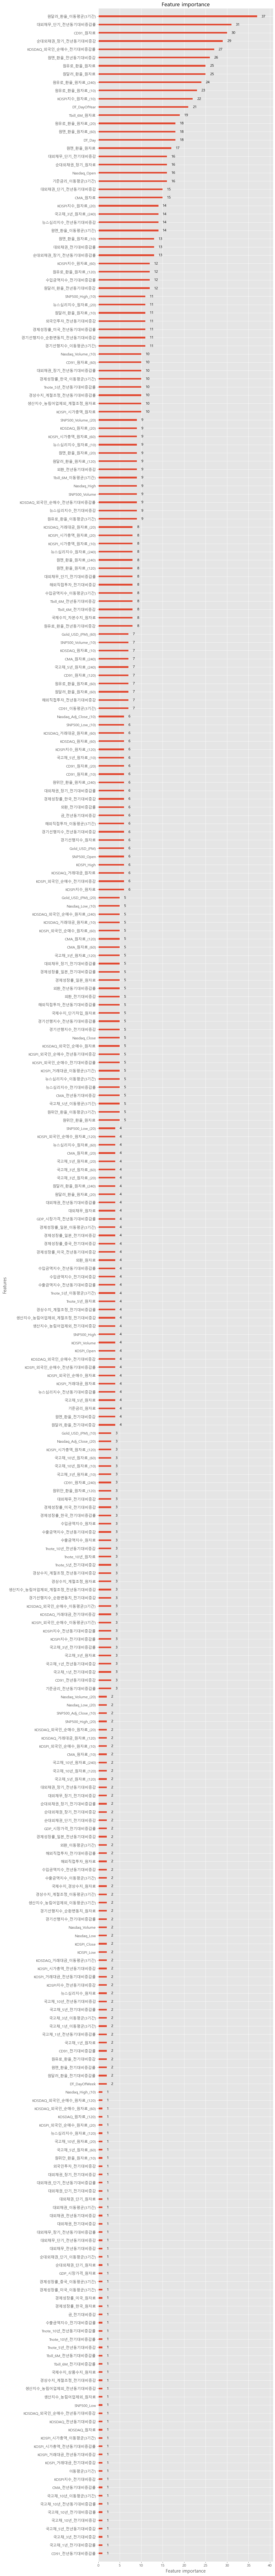

In [14]:
# 피쳐 중요도 그래프 

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,150))
plot_importance(lgbm_wrapper, ax=ax)
plt.show()